In [169]:
#Import everything 
import pylab as plt
import numpy as np

import ffmpeg_wrap
import signal_tools as st
import fft



import os
import shutil
import sys
import ffmpeg
from PIL import Image
import imagehash
import cv2
import torch
from torchvision import models, transforms
from scipy.signal import correlate
from scipy.spatial.distance import euclidean
from fastdtw import fastdtw


plt.rcParams["figure.figsize"] = (7,3)
plt.rcParams["figure.dpi"] = 150

In [53]:
#funtions to generate 2D video signal
def hamming_2d(shape):
    #This function make a 2d hamming window (fading circle)
    #Print Image of blob to see how it looks
    
    i,j = shape
    a = np.r_[[np.hamming(i)]*j].T
    b = np.c_[[np.hamming(j)]*i]
    return a*b


def blob_generator(shape):
    #This function generates a mask over the video.
    #The mask is a grid of four fading circles.
    #Print Image of blob to see how it looks
    i,j = shape
    ii = int(i//2); jj = int(j//2)
    ham2d = hamming_2d([ii,jj])
    arr = np.zeros([i,j])
    arr[:ii,:jj] = ham2d
    arr[:ii,-jj:] = -ham2d
    arr[-ii:,:jj] = -ham2d
    arr[-ii:,-jj:] = ham2d
    return arr



In [100]:
def import_2D_video_signal(filename,shape):
    #Read video and output into 2D frames using ffmepg frame reader.
    frames = [] 
    with ffmpeg_wrap.FfmpegFrameReader(filename, shape) as r:
        f = r.get_next_frame()
        while f is not None:
            frames.append(f)
            f = r.get_next_frame()

    return frames

def convert_2_1D_signal_blob(frames,blob_mask):
    '''
    This function converts the 2D frames into a 1D video signal by applying the blob mask to the video
    by taking the areas of the blob pattern into consideration
    '''

    v = [];
    for f in frames:
        v.append(np.sum(blob_mask.T*f[:,:,0]))
    
    # somewhat normalising the signal
    v = np.array(v)
    v = v - np.mean(v)
    v = v / np.percentile(v, 90)
    return v

def convert_2_1D_signal_phash(frames):
    '''
    This function converts the 2D (image) frames into a 1D video signal by converting
    each frame into a 64-bit hash and then convert that into a int
    '''
    frame_signals= []
    for i in frames:
        img = Image.fromarray(cv2.cvtColor(i, cv2.COLOR_BGR2RGB))
        h = imagehash.phash(img)  # returns 64-bit hash
        frame_signals.append(int(str(h), 16))  # convert to integer
    return np.array(frame_signals)

def convert_2_1D_signal_mpi(frames):
    '''
    This function converts the 2D (image) frames into a 1D video signal by converting
    each frame into a 64-bit hash and then convert that into a int
    '''
    frame_signals= []
    for i in frames:
        gray = (cv2.cvtColor(i, cv2.COLOR_BGR2GRAY))
        value = gray.mean()
        frame_signals.append(value)
    return np.array(frame_signals)

def convert_2_1D_signal_cnn(frames):
    '''
    This function uses AI
    '''
    # 1. Load pretrained ResNet-18
    model = models.resnet18(pretrained=True)
    model.eval()  # Disable training mode

    # 2. Define transformation pipeline
    preprocess = transforms.Compose([
        transforms.Resize((224, 224)),
        transforms.ToTensor(),
        transforms.Normalize(mean=[0.485, 0.456, 0.406],std=[0.229, 0.224, 0.225]),
    ])

    scalars = []
    for i in frames:
        color_img = cv2.cvtColor(i, cv2.COLOR_YUV2RGB)
        img_pil = Image.fromarray(color_img)

        input_tensor = preprocess(img_pil).unsqueeze(0)  # Shape: [1, 3, 224, 224]

        with torch.no_grad():
            features = model(input_tensor)  # Shape: [1, 1000] (logits)

        # 5. Reduce to scalar (option A: vector norm)
        scalar_value = features.norm(p=2).item()
        scalars.append(scalar_value)

    return np.array(scalars)

**Settings**

In the following block a few settings can be chosen for the import of the video etc...

In [8]:
#Resolution of 2D signal (This can be small, to import it)
width_video = 128
height_video = 72

video_shape = (width_video,height_video)

In [12]:
#Convert videos to 1D signal
br_frames = import_2D_video_signal('F:/heidi_files/development/br.mkv',video_shape)
vhs_frames = import_2D_video_signal('F:/heidi_files/development/vhs.mp4',video_shape)

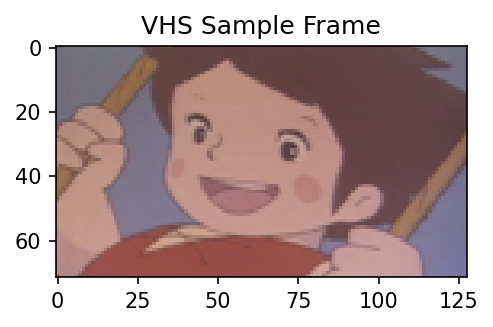

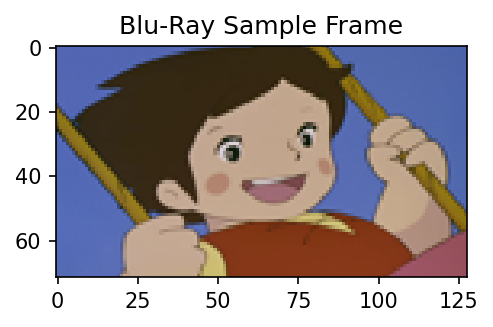

In [115]:
#Just a test to see if the video frames were correctly read
view_frame_num = 1000

plt.figure(figsize=(8,2))
plt.imshow(cv2.cvtColor(vhs_frames[view_frame_num], cv2.COLOR_YUV2RGB))
plt.title('VHS Sample Frame')
plt.show()  # Display the image

plt.figure(figsize=(8,2))
plt.imshow(cv2.cvtColor(br_frames[view_frame_num+90], cv2.COLOR_YUV2RGB))
plt.title('Blu-Ray Sample Frame')
plt.show()  # Display the image

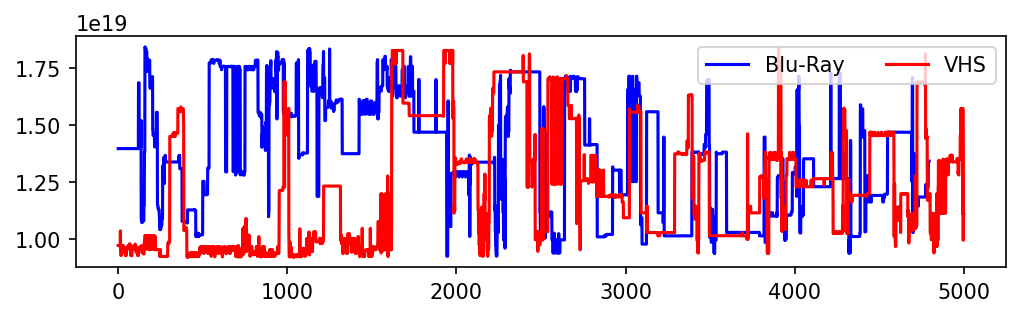

In [117]:
plt.figure(figsize=(8,2))
plt.plot(convert_2_1D_signal_phash(br_frames),color="b",label="Blu-Ray")
plt.plot(convert_2_1D_signal_phash(vhs_frames),color="r",label="VHS")
plt.legend(ncol=2)

#Hierdie tegniek lyk nie of dit regtig werk nie. Dit kan dalk bietjie werk, maar dit gaan moeilik wees.

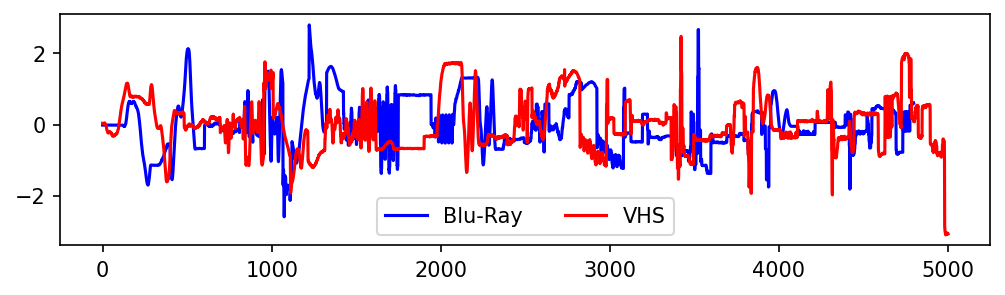

In [118]:
plt.figure(figsize=(8,2))
plt.plot(convert_2_1D_signal_blob(br_frames,blob),color='b',label="Blu-Ray")
plt.plot(convert_2_1D_signal_blob(vhs_frames,blob),color='r',label="VHS")
plt.legend(ncol=2)

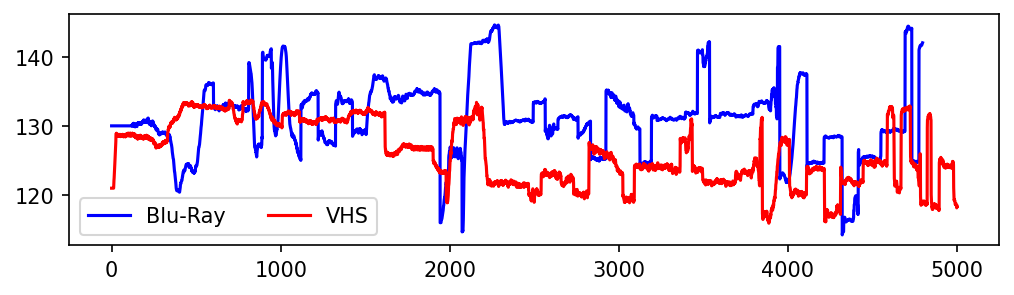

In [119]:
plt.figure(figsize=(8,2))
plt.plot(convert_2_1D_signal_mpi(br_frames),color='b',label="Blu-Ray")
plt.plot(convert_2_1D_signal_mpi(vhs_frames),color='r',label="VHS")
plt.legend(ncol=2)

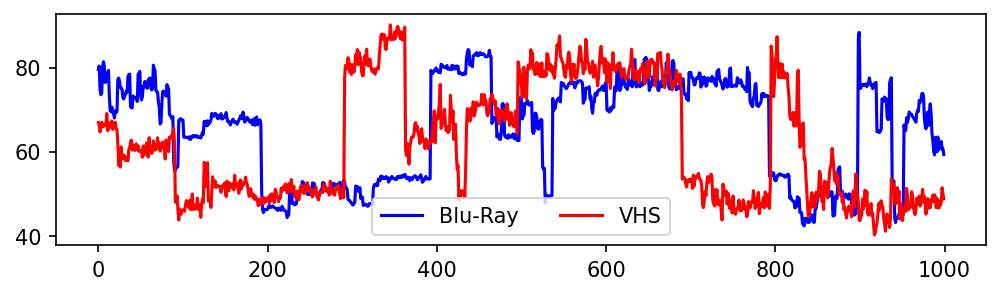

In [185]:
plt.figure(figsize=(8,2))
plt.plot(convert_2_1D_signal_cnn(br_frames[3000:4000]),color='b',label="Blu-Ray")
plt.plot(convert_2_1D_signal_cnn(vhs_frames[3000:4000]),color='r',label="VHS")
plt.legend(ncol=2)

In [186]:
br_sig = convert_2_1D_signal_mpi(br_frames)
vhs_sig = convert_2_1D_signal_mpi(vhs_frames)
# DTW alignment
distance, path = fastdtw(br_sig, vhs_sig, dist=scalar_distance)

# Extract aligned indices
path_br, path_vhs = zip(*path)

# Use interpolation to warp sig2 to sig1
aligned_vhs = np.interp(np.arange(len(br_sig)), path_br, vhs_sig[list(path_vhs)])

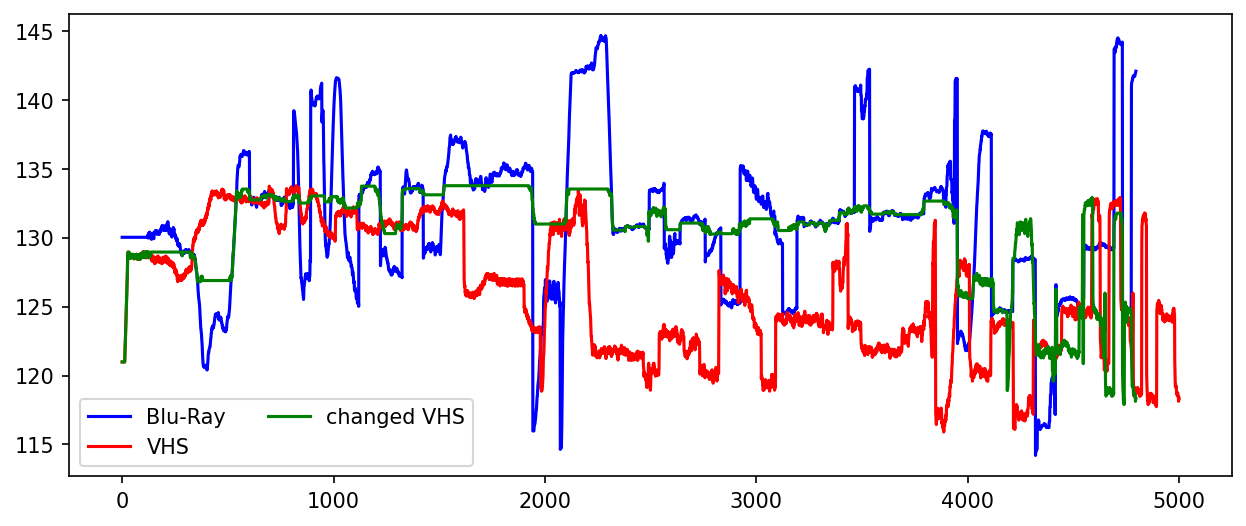

In [189]:
plt.figure(figsize=(10,4))
plt.plot(br_sig,color='b',label="Blu-Ray")
plt.plot(vhs_sig,color='r',label="VHS")
plt.plot(aligned_vhs,color='g',label="changed VHS")
plt.legend(ncol=2)

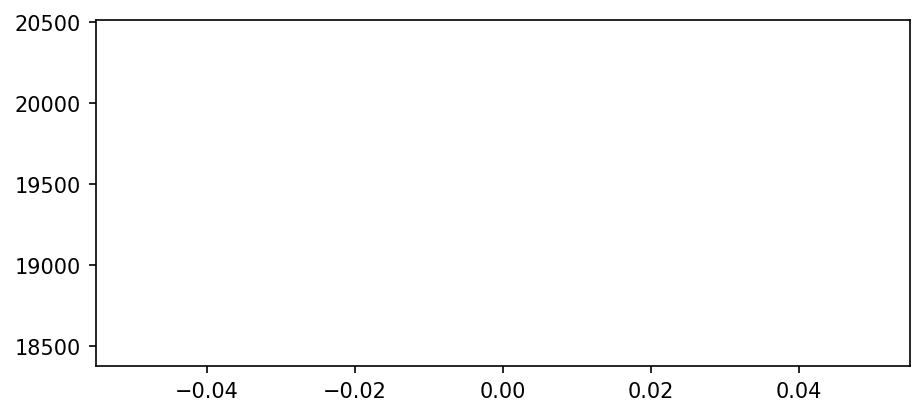